In [68]:
# preprocessing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
# nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

df1 = pd.read_csv('Fake.csv')
df2 = pd.read_csv('True.csv')
fake = df1.copy()
true = df2.copy()
fake['class'] = 'fake' # labeling class
true['class'] = 'true'
collapsed = pd.concat([fake, true], ignore_index=True)
print('before cleaning: ', len(collapsed))

# Data Preprocessing
def preprocessing(text):
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text)
              for word in nltk.word_tokenize(sent)]
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]
    # lower capitalization
    tokens = [word.lower() for word in tokens]
    # lemmatization
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]
    tokens = [lmtzr.lemmatize(word, 'v') for word in tokens]
    # stemming
    stemmer = PorterStemmer()
    tokens = [ stemmer.stem(word) for word in tokens ]
    preprocessed_text= ' '.join(tokens)
    return preprocessed_text

def apply_regular_expression(text):
    text = text.lower()  # 대문자 -> 소문자 변환
    english = re.compile('[^ a-z]')  # 영어 추출 규칙: 띄어 쓰기를 포함한 알파벳
    result = english.sub('', text)  # 위에 설정한 "english"규칙을 "text"에 적용(.sub)시킴
    result = re.sub(' +', ' ', result) # 2개 이상의 공백을(' +') 하나의 공백(' ')으로 바꿈
    return result


collapsed['text'] = collapsed['text'].apply(lambda x: apply_regular_expression(x))
collapsed = collapsed[collapsed['text']!=' ']
collapsed['text'] = collapsed['text'].str.strip() # 빈 문자열 제거
collapsed = collapsed[collapsed['text']!='']
collapsed.dropna(inplace = True)
collapsed.reset_index(inplace=True, drop=True)
collapsed['text'] = collapsed['text'].apply(lambda x: preprocessing(x))

print('after cleaning: ', len(collapsed))
print(collapsed.groupby(['subject','class']).size())
fake = collapsed[collapsed['class']=='fake']
true = collapsed[collapsed['class']=='true']

before cleaning:  44898
after cleaning:  44267
subject          class
Government News  fake      1498
Middle-east      fake       778
News             fake      9050
US_News          fake       783
left-news        fake      4309
politics         fake      6433
politicsNews     true     11271
worldnews        true     10145
dtype: int64


# TF-IDF Cosine Similarity

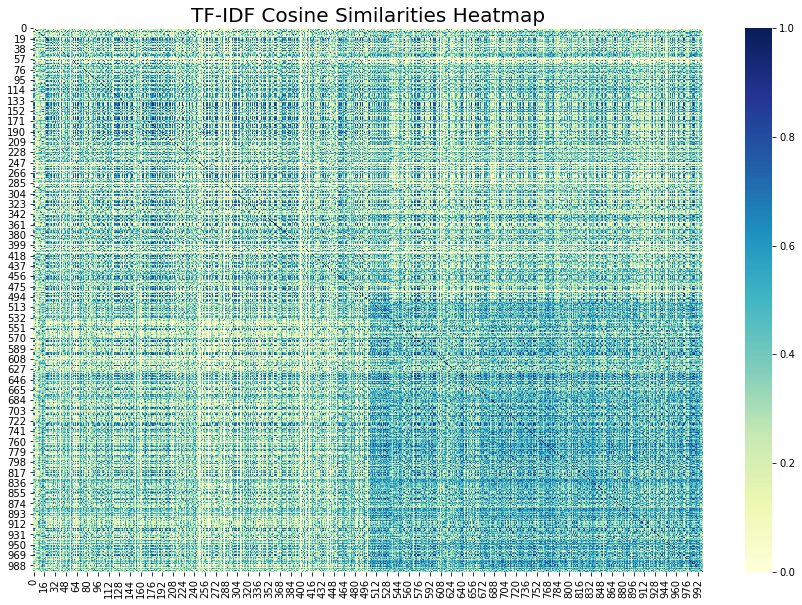

In [106]:
#generate tf-idf term-document matrix
sample_list_f = random.sample(range(len(fake)), 500)
sample_list_t = random.sample(range(len(true)), 500)
sample_f = fake.iloc[sample_list_f]
sample_t = true.iloc[sample_list_t]
collapsed = pd.concat([sample_f, sample_t], ignore_index=True)

# tf-idf & cosine similarities
tfidf = TfidfVectorizer(stop_words="english",
                        analyzer="word",
                        max_features = 100000,
                       min_df = 300, max_df = 950)
A_tfidf_sp = tfidf.fit_transform(collapsed['text'])
doc_similarities = cosine_similarity(A_tfidf_sp,A_tfidf_sp)
doc_similarities = pd.DataFrame(doc_similarities)

# plotting
plt.figure(figsize = (15,10))
ax = sns.heatmap(doc_similarities, annot=False, cmap='YlGnBu')
plt.title('TF-IDF Cosine Similarities Heatmap', fontsize=20)
plt.show()

In [94]:
doc_similarities.iloc[0:500,0:500].mean().mean() #fake-fake

0.3217887111179348

In [90]:
doc_similarities.iloc[500:,500:].mean().mean() #real-real

0.4550823666816895

In [91]:
doc_similarities.iloc[500:,:500].mean().mean() #real-fake

0.29803141542887956

# TF-IDF WordCloud Comparing

In [95]:
from wordcloud import WordCloud
import itertools
from collections import Counter
def generate_wordcloud(words_tem, title):
    word_cloud = WordCloud(width = 512, height = 512,
                           background_color='black',
                           stopwords= None,
                           max_words=100).generate_from_frequencies(words_tem)
    plt.figure(figsize=(8,20),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title('{} Word Cloud'.format(title), fontsize=20)
    plt.show()
    
sample_list_f_larger = random.sample(range(len(fake)), 1000)
sample_list_t_larger = random.sample(range(len(true)), 1000)
sample_f_larger = fake.iloc[sample_list_f_larger]
sample_t_larger = true.iloc[sample_list_t_larger]
sample_f_larger.reset_index(inplace=True, drop=True)
sample_t_larger.reset_index(inplace=True, drop=True)

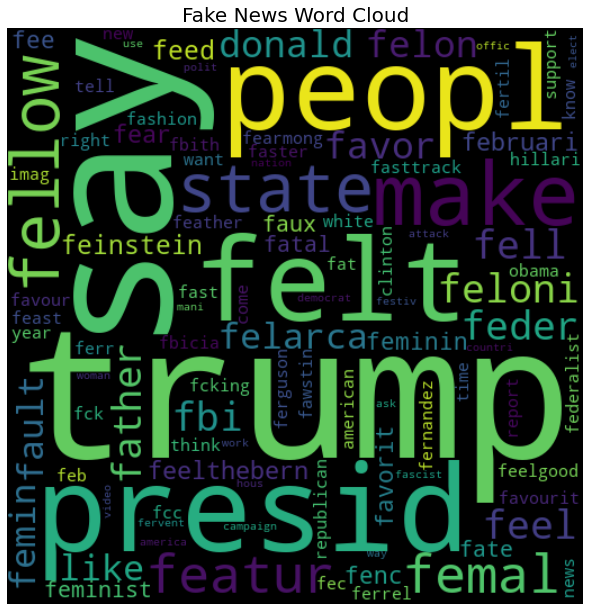

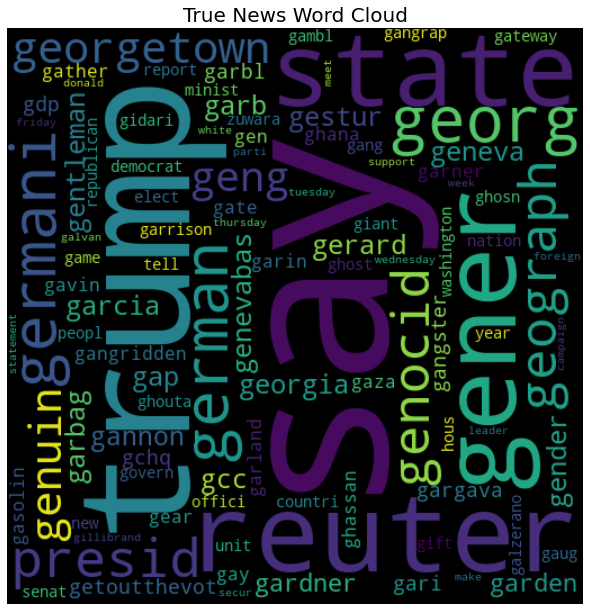

In [97]:
# fake dictionaries
tfidf_fake = TfidfVectorizer(stop_words="english",
                            max_features=10000)
A_tfidf_sp_fake = tfidf_fake.fit_transform(sample_f_larger['text'])
tfidf_dict_fake = tfidf_fake.get_feature_names()
data_array_fake = A_tfidf_sp_fake.toarray()
data_fake = pd.DataFrame(data_array_fake, columns=tfidf_dict_fake)
temp = [data_fake.iloc[i].sort_values(ascending=False).head(100).index for i in range(len(data_fake))]
word_lists = list(itertools.chain(*temp))
word_dict = Counter(word_lists)
generate_wordcloud(word_dict, 'Fake News')
 

# true dictionaries
tfidf_true = TfidfVectorizer(stop_words="english",
                        max_features = 10000)
A_tfidf_sp_true = tfidf_true.fit_transform(sample_t_larger['text'])
tfidf_dict_true = tfidf_true.get_feature_names()

data_array_true = A_tfidf_sp_true.toarray()
data_true = pd.DataFrame(data_array_true, columns=tfidf_dict_true)
temp = [data_true.iloc[i].sort_values(ascending=False).head(100).index for i in range(len(data_true))]
word_lists = list(itertools.chain(*temp))
word_dict = Counter(word_lists)
generate_wordcloud(word_dict, 'True News')

# Key-Word T-SNE

In [238]:
tfidf = TfidfVectorizer(stop_words="english",
                        analyzer="word",
                        max_features = 100)
A_tfidf_sp = tfidf.fit_transform(collapsed['text'])
tfidf_dict = tfidf.get_feature_names()
data_array = A_tfidf_sp.toarray()
data = pd.DataFrame(data_array, columns=tfidf_dict)

In [239]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=50)
# pca.fit(data_array.T)
# feature_reduced = pca.transform(data_array.T)
# feature_reduced = feature_reduced.T

In [249]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=100000000000, verbose=1)
Z = tsne.fit_transform(data_array.T)
print(Z[0:5])
print('Top words: ',len(Z))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.991819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.408859
[t-SNE] KL divergence after 2250 iterations: 0.616496
[[-0.87491035  0.43806347]
 [-0.545122    0.2774295 ]
 [-2.4945233  -0.8982504 ]
 [-3.4124296  -1.8872594 ]
 [-2.315597    0.25996846]]
Top words:  100


<ipython-input-251-0a3a51567f79>:5: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"),


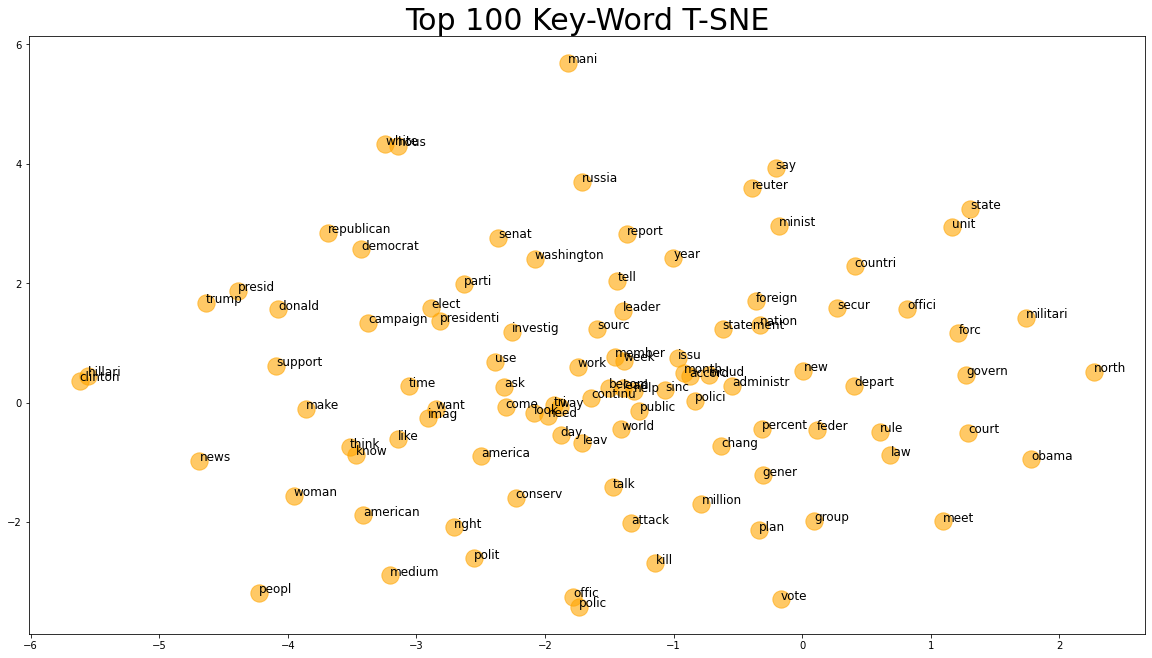

In [251]:
plt.figure(figsize=(20,11))
plt.scatter(Z[:,0], Z[:,1], alpha = 0.6, s = 300, color='orange')
plt.title('Top 100 Key-Word T-SNE', fontsize=30)
for i in range(len(tfidf_dict)):
    plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"),
                 xy=(Z[i,0], Z[i,1]), fontsize=12)
plt.show()

# Document PCA + T-SNE

In [188]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(data)
feature_reduced = pca.transform(data)

tsne = TSNE(n_components=2, n_iter=1000, verbose=1)
Z = tsne.fit_transform(feature_reduced)
Z = pd.DataFrame(Z, columns = ['component 0', 'component 1'])
Z['class']= collapsed['class']
tsne_df_0 = Z[Z['class'] == 'true']
tsne_df_1 = Z[Z['class'] == 'fake']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.295659
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.564445
[t-SNE] KL divergence after 1000 iterations: 1.425019


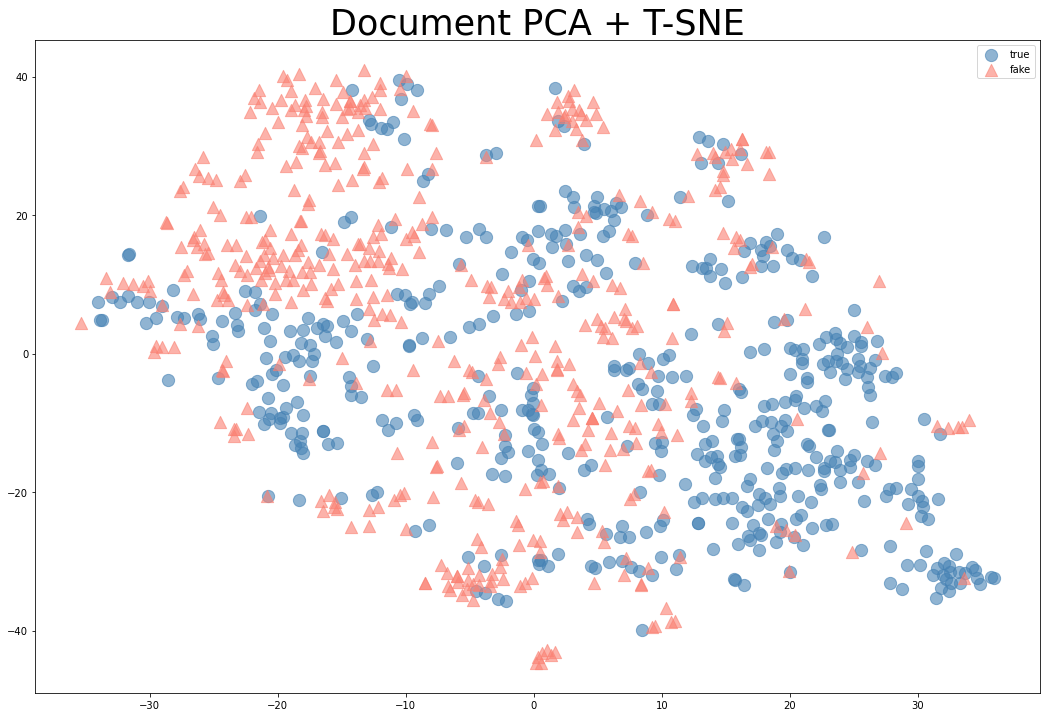

In [196]:
# target 별 시각화
plt.figure(figsize=(18,12))
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'],
            label = 'true', alpha = 0.6, linewidth = 1,
            s = 150, color='steelblue', marker="o")
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'],
            label = 'fake', alpha = 0.6, linewidth = 1,
            s = 150, color='salmon', marker="^")
plt.legend()
plt.title('Document PCA + T-SNE', fontsize=35)
plt.show()